In [1]:
%matplotlib inline
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
import matplotlib.pyplot as plt

import geopandas as gpd
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np

In [2]:
spark = SparkSession.builder.appName('AcidSoils').getOrCreate()

23/01/25 19:13:20 WARN Utils: Your hostname, tamirats-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.46.13.191 instead (on interface en0)
23/01/25 19:13:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/25 19:13:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
source = gpd.read_file("data/GTK_ASsoil_obs.csv")
source.head(4)

,POINT_X,POINT_Y,CLASS,geometry
0,441468.7125,7184281.005,ASS,None
1,441852.3101,7186002.327,ASS,None
2,442236.5012,7185249.359,ASS,None
3,420520.3581,7208257.978,ASS,None


In [4]:
geom = gpd.points_from_xy(source.POINT_X.astype("float"), source.POINT_Y.astype("float"))
points = gpd.GeoDataFrame(source.CLASS, crs="EPSG:3067", geometry=geom).to_crs("WGS84")
points.head(4)

,CLASS,geometry
0,ASS,POINT (25.76894 64.77799)
1,ASS,POINT (25.77630 64.79350)
2,ASS,POINT (25.78469 64.78681)
3,ASS,POINT (25.31512 64.98873)


In [5]:
points["x"] = points.geometry.x
points["y"] = points.geometry.y
points.head(4)

,CLASS,geometry,x,y
0,ASS,POINT (25.76894 64.77799),25.768938,64.777988
1,ASS,POINT (25.77630 64.79350),25.776304,64.793496
2,ASS,POINT (25.78469 64.78681),25.784691,64.786808
3,ASS,POINT (25.31512 64.98873),25.315115,64.988732


In [6]:
df = spark.createDataFrame(points)
df.show(4,truncate=False)

+-----+---------------------------+------------------+-----------------+
|CLASS|geometry                   |x                 |y                |
+-----+---------------------------+------------------+-----------------+
|ASS  |{105553155633056, false, 2}|25.768937832725747|64.77798766173387|
|ASS  |{105553155629024, false, 2}|25.77630416654702 |64.79349633623737|
|ASS  |{105553155629120, false, 2}|25.784691167397362|64.7868078298281 |
|ASS  |{105553155636416, false, 2}|25.315115332474953|64.98873249710591|
+-----+---------------------------+------------------+-----------------+
only showing top 4 rows



In [7]:
df.groupby('CLASS').count().show()

+-------+-----+
|  CLASS|count|
+-------+-----+
|    ASS| 3490|
|non-ASS| 2334|
+-------+-----+



## Add point ID

In [8]:
TILE_SIZE = 256
ZOOM = 9

@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_pixel(lon, lat, zoom=ZOOM):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(px), int(py)]
    
    
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_tile(lon, lat, zoom=ZOOM):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(zoom), int(tx), int(ty)]

In [9]:
df_points = (
    df
    .withColumn("pixel", project_pixel(df.x, df.y))
    .withColumn("tile", project_tile(df.x, df.y))
    .withColumn("point_id", F.monotonically_increasing_id())
    .drop("geometry")
)

df_points.show(4)


+-----+------------------+-----------------+----------+-------------+--------+
|CLASS|                 x|                y|     pixel|         tile|point_id|
+-----+------------------+-----------------+----------+-------------+--------+
|  ASS|25.768937832725747|64.77798766173387|[166, 252]|[9, 292, 133]|       0|
|  ASS| 25.77630416654702|64.79349633623737|[168, 239]|[9, 292, 133]|       1|
|  ASS|25.784691167397362| 64.7868078298281|[171, 245]|[9, 292, 133]|       2|
|  ASS|25.315115332474953|64.98873249710591|   [0, 71]|[9, 292, 133]|       3|
+-----+------------------+-----------------+----------+-------------+--------+
only showing top 4 rows



## Combine output class with pixel coordinates

In [10]:
(
    df_points
    .select(
        "point_id", 
        "pixel", 
        "tile"
    )
    .withColumn("pixel_i", F.col("pixel")[0])
    .withColumn("pixel_j", F.col("pixel")[1])
    .withColumn("data", F.array(F.col("pixel_i"), F.col("pixel_j"), F.col("point_id")))
    .show(5)
)

+--------+----------+-------------+-------+-------+-------------+
|point_id|     pixel|         tile|pixel_i|pixel_j|         data|
+--------+----------+-------------+-------+-------+-------------+
|       0|[166, 252]|[9, 292, 133]|    166|    252|[166, 252, 0]|
|       1|[168, 239]|[9, 292, 133]|    168|    239|[168, 239, 1]|
|       2|[171, 245]|[9, 292, 133]|    171|    245|[171, 245, 2]|
|       3|   [0, 71]|[9, 292, 133]|      0|     71|   [0, 71, 3]|
|       4| [11, 238]|[9, 292, 133]|     11|    238| [11, 238, 4]|
+--------+----------+-------------+-------+-------+-------------+
only showing top 5 rows



In [11]:
TILES_BASIC = "/Users/tamiratatsemegiorgis/project/MapTilesViewer/basic/{z}/{x}/{y}.png"
#TILES_HILLSHADE ="/Users/tamiratatsemegiorgis/project/TILES_hillshade/{z}/{x}/{y}.png"

@F.udf(returnType=T.ArrayType(T.ArrayType(T.LongType())))
def load_image_data(tile, pixel_data, tiles):
    """
    tiles: folder with tiles
    """
    (z, tx, ty) = tile
    fname = tiles.format(z=z, x=tx, y=ty)
    im = Image.open(fname)
    arr_img= np.array(im)

    data = []
    for i, j, pid in pixel_data:
        if arr_img.shape[-1] == 3:
            # color image
            r, g, b = arr_img[i, j] # 3 dim array, ?
            data.append([int(r), int(g), int(b), pid])
        else:
            # grayscale image
            gray, alpha = arr_img[i, j]
            data.append([int(gray), pid])
    
    return data


In [12]:
df_basic_raw = (
    df_points
    .select(
        "point_id", 
        "pixel", 
        "tile"
    )
    .withColumn("pixel_i", F.col("pixel")[0])
    .withColumn("pixel_j", F.col("pixel")[1])
    .withColumn("pixel_data", F.array(F.col("pixel_i"), F.col("pixel_j"), F.col("point_id")))

    # processing
    .groupby("tile")
    .agg(
        F.collect_list("pixel_data").alias("pixel_data_list"),
    )
    .withColumn("data_basic", load_image_data(F.col("tile"), F.col("pixel_data_list"), F.lit(TILES_BASIC)))
)

df_basic_raw.show(10) 

+-------------+--------------------+--------------------+
|         tile|     pixel_data_list|          data_basic|
+-------------+--------------------+--------------------+
|[9, 288, 136]|[[250, 244, 459],...|[[75, 86, 56, 459...|
|[9, 293, 132]|[[6, 2, 108], [4,...|[[127, 142, 109, ...|
|[9, 292, 131]|[[176, 223, 98], ...|[[111, 118, 85, 9...|
|[9, 289, 136]|[[164, 93, 393], ...|[[93, 104, 74, 39...|
|[9, 292, 133]|[[166, 252, 0], [...|[[107, 101, 75, 0...|
|[9, 288, 137]|[[196, 59, 612], ...|[[56, 72, 46, 612...|
|[9, 290, 136]|[[37, 246, 398], ...|[[45, 68, 24, 398...|
|[9, 291, 130]|[[247, 154, 220],...|[[88, 105, 69, 22...|
|[9, 292, 134]|[[32, 112, 52], [...|[[173, 192, 170, ...|
|[9, 293, 134]|[[162, 52, 245], ...|[[109, 109, 83, 2...|
+-------------+--------------------+--------------------+
only showing top 10 rows



In [13]:
df_basic = (
    df_basic_raw
    .select(F.explode("data_basic").alias("data"))
    .select(
        F.col("data")[0].alias("basic_r"),
        F.col("data")[1].alias("basic_g"),
        F.col("data")[2].alias("basic_b"),
        F.col("data")[3].alias("point_id"),
    )
    
    # put back points class
    .join(
        df_points.select("CLASS", "point_id"),
        
        on="point_id",
        
    )
)

df_basic.show(4)

+--------+-------+-------+-------+-----+
|point_id|basic_r|basic_g|basic_b|CLASS|
+--------+-------+-------+-------+-----+
|      26|    118|    111|     95|  ASS|
|      29|    107|    102|     82|  ASS|
|     474|     53|     75|     39|  ASS|
|      65|     86|    108|     70|  ASS|
+--------+-------+-------+-------+-----+
only showing top 4 rows



In [14]:
df_basic.columns

['point_id', 'basic_r', 'basic_g', 'basic_b', 'CLASS']

In [15]:
df_data = (
    df_basic
   
    .select(
        'basic_r',
        'basic_g',
        'basic_b',
        "point_id", 
        (F.col("CLASS") == "ASS").astype("int").alias("class"),
        
       # F.array(data_columns).alias("features"),
    )
)

df_data.show(4)

+-------+-------+-------+--------+-----+
|basic_r|basic_g|basic_b|point_id|class|
+-------+-------+-------+--------+-----+
|    118|    111|     95|      26|    1|
|    107|    102|     82|      29|    1|
|     53|     75|     39|     474|    1|
|     86|    108|     70|      65|    1|
+-------+-------+-------+--------+-----+
only showing top 4 rows



In [16]:
df_data.printSchema()

root
 |-- basic_r: long (nullable = true)
 |-- basic_g: long (nullable = true)
 |-- basic_b: long (nullable = true)
 |-- point_id: long (nullable = true)
 |-- class: integer (nullable = true)



## Train a random forest

In [17]:
#convert to pandas dataframe
df_data_p=df_data.toPandas()
df_data_p

,basic_r,basic_g,basic_b,point_id,class
0,118,111,95,26,1
1,107,102,82,29,1
2,53,75,39,474,1
3,86,108,70,65,1
4,80,86,58,191,1
...,...,...,...,...,...
5819,15,23,2,60129542557,0
5820,99,108,77,60129542806,0
5821,7,38,56,60129542145,1
5822,102,111,80,60129542427,0


In [18]:
df_data_p['class'].value_counts()

1    3490
0    2334
Name: class, dtype: int64

In [22]:
X= df_data_p.iloc[:,0:3].values
y=df_data_p.iloc[:,-1].values
X

array([[118, 111,  95],
       [107, 102,  82],
       [ 53,  75,  39],
       ...,
       [  7,  38,  56],
       [102, 111,  80],
       [ 81,  85,  52]])

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=66)

clf = RandomForestClassifier(n_estimators=5, random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=5, random_state=0)

In [24]:
print(X_train.shape, y_test.shape)

(4368, 3) (1456,)


## Evaluate our Random Forest Classifier

In [25]:
print("Accuracy on training set: {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(X_test, y_test)))


Accuracy on training set: 0.902
Accuracy on test set: 0.565


In [26]:
prodction_class = clf.predict(X_test)
prodction_class

array([1, 1, 1, ..., 0, 1, 1], dtype=int32)

In [28]:
#confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
confusion_matrix(y_test, prodction_class)

array([[240, 345],
       [288, 583]])

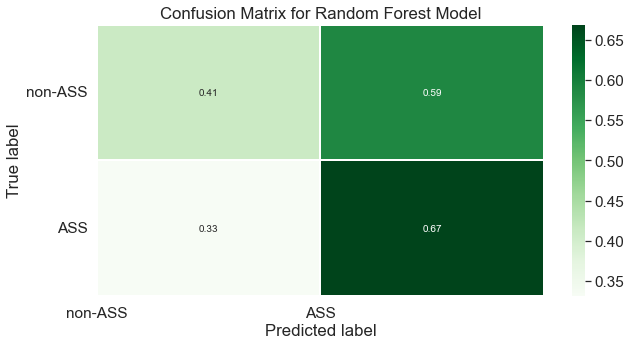

In [30]:
#Graph the confusion matrix data
matrix = confusion_matrix(y_test, prodction_class)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(10,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['non-ASS','ASS']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()